In [1]:
# requirements
# %pip install git+https://github.com:jotaf98/simple-tar-dataset.git

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.1.1+cu121


In [3]:
torch.cuda.is_available()

True

In [4]:
!ls /home/mak/ssd/imagenet/ILSVRC/Data/CLS-LOC/train

n01440764  n02037110  n02125311  n02799071  n03443371  n03929855  n04435653
n01443537  n02051845  n02127052  n02802426  n03444034  n03930313  n04442312
n01484850  n02056570  n02128385  n02804414  n03445777  n03930630  n04443257
n01491361  n02058221  n02128757  n02804610  n03445924  n03933933  n04447861
n01494475  n02066245  n02128925  n02807133  n03447447  n03935335  n04456115
n01496331  n02071294  n02129165  n02808304  n03447721  n03937543  n04458633
n01498041  n02074367  n02129604  n02808440  n03450230  n03938244  n04461696
n01514668  n02077923  n02130308  n02814533  n03452741  n03942813  n04462240
n01514859  n02085620  n02132136  n02814860  n03457902  n03944341  n04465501
n01518878  n02085782  n02133161  n02815834  n03459775  n03947888  n04467665
n01530575  n02085936  n02134084  n02817516  n03461385  n03950228  n04476259
n01531178  n02086079  n02134418  n02823428  n03467068  n03954731  n04479046
n01532829  n02086240  n02137549  n02823750  n03476684  n03956157  n04482393
n01534433  n

In [5]:
training_folder_name = '/home/mak/ssd/imagenet/ILSVRC/Data/CLS-LOC/train'
val_folder_name = '/home/mak/ssd/imagenet/ILSVRC/Data/CLS-LOC/val'

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878', 'n01530575', 'n01531178', 'n01532829', 'n01534433', 'n01537544', 'n01558993', 'n01560419', 'n01580077', 'n01582220', 'n01592084', 'n01601694', 'n01608432', 'n01614925', 'n01616318', 'n01622779', 'n01629819', 'n01630670', 'n01631663', 'n01632458', 'n01632777', 'n01641577', 'n01644373', 'n01644900', 'n01664065', 'n01665541', 'n01667114', 'n01667778', 'n01669191', 'n01675722', 'n01677366', 'n01682714', 'n01685808', 'n01687978', 'n01688243', 'n01689811', 'n01692333', 'n01693334', 'n01694178', 'n01695060', 'n01697457', 'n01698640', 'n01704323', 'n01728572', 'n01728920', 'n01729322', 'n01729977', 'n01734418', 'n01735189', 'n01737021', 'n01739381', 'n01740131', 'n01742172', 'n01744401', 'n01748264', 'n01749939', 'n01751748', 'n01753488', 'n01755581', 'n01756291', 'n01768244', 'n01770081', 'n01770393', 'n01773157', 'n01773549', 'n01773797', 'n01774384', 'n01774750'

In [6]:
# overall params

# name for checkpoints and tensorboard
name = "resnet_sgd_6"

# dataset loading options
cache_dataset = False
cache_path = "train_cache"
workers = 16

batch_size = 32
# optimizer params
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
# step scheduler params
lr_step_size = 30
lr_gamma = 0.1

# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# resume training options
resume_training = True

Using cuda device


In [7]:
if cache_dataset and os.path.exists(cache_path):
        # Attention, as the transforms are also cached!
        print(f"Loading dataset_train from {cache_path}")
        train_dataset, _ = torch.load(cache_path)
else:
    train_transformation = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
            transforms.RandomHorizontalFlip(0.5),
            # Normalize the pixel values (in R, G, and B channels)
            transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    train_dataset = torchvision.datasets.ImageFolder(
        root=training_folder_name,
        transform=train_transformation
    )
    if cache_dataset:
        print(f"Saving dataset_train to {cache_path}")
        torch.save((train_dataset, training_folder_name), cache_path)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers = workers,
        pin_memory=True,
    )

In [8]:
val_transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        #transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        #transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        transforms.Resize(size=256),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_dataset = torchvision.datasets.ImageFolder(
    root=val_folder_name,
    transform=val_transformation
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=workers,
    shuffle=False,
    pin_memory=True
)
for X, y in val_loader:
    break
X.shape, X

(torch.Size([64, 3, 224, 224]),
 tensor([[[[-4.7711e-01, -3.6601e-01, -5.3800e-01,  ...,  1.0137e+00,
             2.4509e-01,  6.9607e-01],
           [-5.8588e-01, -7.8899e-01, -3.5266e-01,  ...,  8.1986e-01,
             6.8886e-01, -6.7291e-02],
           [-6.6280e-01, -9.7669e-02,  8.1905e-02,  ...,  7.0042e-01,
             9.5710e-01,  1.3988e-01],
           ...,
           [-3.6054e-01, -3.8499e-01, -3.8313e-01,  ..., -1.0405e-01,
            -3.4108e-01, -4.0193e-01],
           [-2.5560e-01, -2.9621e-01, -3.9457e-01,  ..., -4.4628e-01,
             3.5286e-01,  1.1809e+00],
           [-2.5682e-01, -2.5387e-01, -1.1697e-01,  ..., -3.0388e-01,
            -3.7561e-01, -4.0786e-01]],
 
          [[-6.7600e-01, -5.8653e-01, -1.0550e-01,  ...,  1.2090e+00,
             4.8056e-01,  9.4219e-01],
           [-5.7168e-01, -8.0709e-01, -3.3629e-01,  ...,  1.0237e+00,
             8.4371e-01,  1.3361e-01],
           [-6.3877e-01, -2.0701e-01,  1.4978e-02,  ...,  9.0860e-01,
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


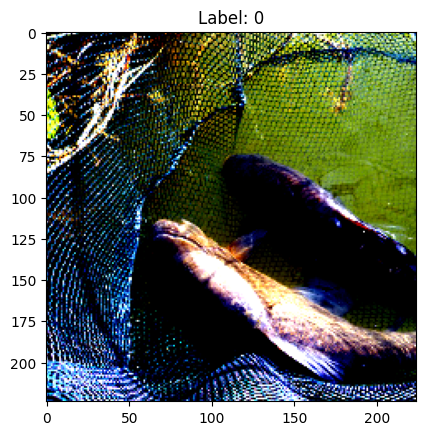

In [9]:
import matplotlib.pyplot as plt
def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()
show_image(X[0], y[0])

In [10]:
for X, y in train_loader:
    break
X.shape, X

(torch.Size([32, 3, 224, 224]),
 tensor([[[[-1.1291, -1.1480, -1.1710,  ..., -1.7178, -1.6878, -1.6776],
           [-1.1056, -1.1238, -1.1469,  ..., -1.6978, -1.6820, -1.6644],
           [-1.1236, -1.1128, -1.1019,  ..., -1.6954, -1.6666, -1.6481],
           ...,
           [-2.0095, -2.0564, -2.0392,  ...,  2.0182,  2.0636,  2.0849],
           [-2.0543, -2.0394, -2.0435,  ...,  2.0870,  2.0049,  1.9090],
           [-2.0282, -2.0306, -2.0271,  ...,  1.7031,  1.6066,  1.5102]],
 
          [[-1.1043, -1.1336, -1.1330,  ..., -1.7275, -1.7043, -1.7051],
           [-1.1134, -1.1145, -1.1154,  ..., -1.7183, -1.7095, -1.7138],
           [-1.1401, -1.1365, -1.1176,  ..., -1.7164, -1.7000, -1.6880],
           ...,
           [-2.0544, -2.1023, -2.0847,  ...,  2.0007,  1.9932,  1.9690],
           [-2.1001, -2.0849, -2.0891,  ...,  1.7927,  1.5650,  1.4249],
           [-2.0734, -2.0759, -2.0723,  ...,  1.3158,  1.1042,  1.0412]],
 
          [[-0.5973, -0.5832, -0.6100,  ..., -1.4788, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


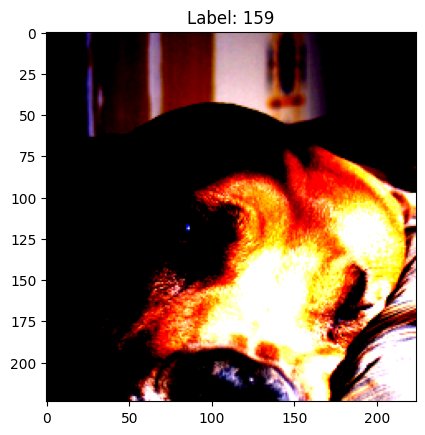

In [11]:
show_image(X[0], y[0])

In [12]:
#model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)
model = torchvision.models.resnet18().to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=lr, momentum=momentum, weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

In [15]:
loss_fn(model(X.to(device)), y.to(device))

tensor(6.9227, device='cuda:0', grad_fn=<NllLossBackward0>)

In [16]:
len(train_loader)

40037

In [17]:
len(train_loader.dataset)

1281167

In [18]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step = epoch * size + current
            writer.add_scalar('training loss',
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [19]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch * len(train_dataloader.dataset)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
start = time.time()
#test(val_loader, model, loss_fn, epoch=0, writer=None, calc_acc5=True)
print("Elapsed: ", time.time() - start)

Elapsed:  0.00013327598571777344


In [21]:
start_epoch = 0
checkpoint_path = os.path.join("checkpoints", name, f"checkpoint.pth")
if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    start_epoch = checkpoint["epoch"] + 1
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
Path(os.path.join("checkpoints", name)).mkdir(parents=True, exist_ok=True)


writer = SummaryWriter('runs/' + name)    
for epoch in range(start_epoch, 100):
    test(val_loader, model, loss_fn, epoch, writer, train_dataloader=train_loader, calc_acc5=True)
    train(train_loader, model, loss_fn, optimizer, epoch=epoch, writer=writer)
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, os.path.join("checkpoints", name, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join("checkpoints", name, f"checkpoint.pth"))
    lr_scheduler.step()
    test(val_loader, model, loss_fn, epoch + 1, writer, train_dataloader=train_loader, calc_acc5=True)

Test Error: 
 Accuracy: 0.1%, Avg loss: 7.022205 

Test Error: 
 Accuracy-5: 0.5%, Avg loss: 7.022205 

loss: 6.987342  [   32/1281167], 0.002498%
loss: 6.915641  [ 3232/1281167], 0.252270%
Done in  5.686280965805054  seconds
Remaining time (seconds):  2270.8429581362752
loss: 6.907534  [ 6432/1281167], 0.502042%
Done in  6.059851884841919  seconds
Remaining time (seconds):  2413.9704038824884
loss: 6.894608  [ 9632/1281167], 0.751815%
Done in  6.74222731590271  seconds
Remaining time (seconds):  2679.055628164485
loss: 6.899424  [12832/1281167], 1.001587%
Done in  5.959080934524536  seconds
Remaining time (seconds):  2361.9096615906806
loss: 6.897524  [16032/1281167], 1.251359%
Done in  6.3856377601623535  seconds
Remaining time (seconds):  2524.5918211571875
loss: 6.871422  [19232/1281167], 1.501131%
Done in  6.4295995235443115  seconds
Remaining time (seconds):  2535.542710857466
loss: 6.815678  [22432/1281167], 1.750904%
Done in  6.309725999832153  seconds
Remaining time (seconds):

In [ ]:
def blank_train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        batch_size = len(X)
        if batch % 100 == 0:
            current = (batch + 1) * batch_size
            step = epoch * len(dataloader) + batch
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = speed * remaining_steps
                print("Remaining time (seconds): ", remaining_time)
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [ ]:
# blank_train(train_loader, model, loss_fn, optimizer, epoch=0, writer=None)

In [ ]:
import tarimagefolder
from tarimagefolder import TarImageFolder

In [ ]:
start = time.time()
train_dataset_tar = TarImageFolder("/home/mak/ssd/tmp/folders.tar", transform=train_transformation, root_in_archive="folders")
print("Done in ", time.time() - start)

In [ ]:
len(train_dataset_tar.samples)

In [ ]:
len(train_dataset_tar.idx_to_class)

In [ ]:
train_sampler_tar = torch.utils.data.RandomSampler(train_dataset_tar)
train_loader_tar = torch.utils.data.DataLoader(
        train_dataset_tar,
        batch_size=batch_size,
        sampler=train_sampler_tar,
    
        num_workers = 0,
    
        pin_memory=True,
    )

In [ ]:
start = time.time()
for X, y in train_loader_tar:
    break
print("Done in ", time.time() - start)

In [ ]:
start = time.time()
for X, y in train_loader_tar:
    break
print("Done in ", time.time() - start)

In [ ]:
blank_train(train_loader_tar, model, loss_fn, optimizer, epoch=0, writer=None)